In [5]:
%load_ext autoreload

%autoreload 2
import sys
import pyccl as ccl
import numpy as np
from clmm import Cosmology
from multiprocessing import Pool
import matplotlib.pyplot as plt
import emcee
import time
import pickle
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

sys.path.append('../../modeling')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_modeling_richness_mass_relation as rm_relation

import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing
def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
#sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
sys.path.append('../../')
import _redshift_richness_bins as analysis
fid = [3.345953364933381,
 0.06378674560099672,
 2.2274595352385975,
 0.5634900828247924,
 -0.04529427946062734,
 0.09764409931399064]
mcmc = [3.37806162, 0.08305871, 2.19424451, 0.52628467, 0.193449  ,
       0.13711268]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#cosmology
Omega_m_true = 0.2648
Omega_b_true = 0.0448
Omega_c_true = Omega_m_true - Omega_b_true
sigma8_true = 0.8
H0_true = 71
ns_true = 0.963
True_value = [Omega_m_true, sigma8_true]
cosmo_clmm = Cosmology(H0 = H0_true, Omega_dm0 = Omega_c_true, Omega_b0 = Omega_b_true, Omega_k0 = 0.0)
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = H0_true/100, sigma8 = sigma8_true, n_s=ns_true)
#halo model
massdef = ccl.halos.massdef.MassDef(200, 'critical')
hmd = ccl.halos.hmfunc.MassFuncDespali16(mass_def=massdef)
#purity
a_nc, b_nc, a_rc, b_rc = np.log(10)*0.8612, np.log(10)*0.3527, 2.2183, -0.6592
theta_purity = [a_nc, b_nc, a_rc, b_rc]
#completeness
a_nc, b_nc, a_mc, b_mc = 1.1321, 0.7751, 13.31, 0.2025
theta_completeness = [a_nc, b_nc, a_mc, b_mc]
#rm_relation
log10m0, z0 = np.log10(10**14.3), .5
#proxy_mu0, proxy_muz, proxy_mulog10m =  3.091, 0, 1.05*np.log(10)
proxy_mu0, proxy_muz, proxy_mulog10m =fid[:3]
#proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.594, 0., 0.026*np.log(10)
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m = fid[3:]
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

richness_grid = np.logspace(np.log10(20), np.log10(200), 200)
logm_grid = np.linspace(12, 15.5,200)
z_grid = np.linspace(.2, 1, 102)

In [14]:
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':theta_purity, 'params_completeness': theta_completeness, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd, 'params_concentration_mass_relation': 'Duffy08'}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 
           'compute_completeness':True, 'compute_purity':True , 'compute_halo_bias':True}

count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)

data = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_true.pkl', allow_pickle=True)
profiles = data['stacked profile']
covariances = data['stacked covariance']
r = profiles['radius'][0]

#cluster_lensing = np.zeros([len(r), len(logm_grid), len(z_grid)])#
cluster_lensing = cl_lensing.compute_cluster_lensing(r, 'Duffy08', logm_grid, z_grid, cosmo, cosmo_clmm, two_halo=False
                                                    )

Z_bin = analysis.Z_bin
Richness_bin = analysis.Obs_bin
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
DS_obs = np.zeros([len(r), len(Richness_bin), len(Z_bin)])
Err_obs = np.zeros([len(r), len(Richness_bin), len(Z_bin)])

for i, z_bin in enumerate(Z_bin):
    mask_z = (profiles['z_mean'] > z_bin[0])*(profiles['z_mean'] < z_bin[1])
    for j, richness_bin in enumerate(Richness_bin):
        mask_richness = (profiles['obs_mean'] > richness_bin[0])*(profiles['obs_mean'] < richness_bin[1])
        mask_tot = mask_z * mask_richness
        DS_obs[:,j,i] = profiles['gt'][mask_tot][0]
        Err_obs[:,j,i] = covariances['cov_t'][mask_tot][0].diagonal()**.5

In [15]:
Omegaredmapper = 439.78987
Omega = 4*np.pi*(Omegaredmapper/(360**2/np.pi))

In [16]:
def DS(theta_rm_new, purity, completeness):
    
    params_new = {'params_purity':theta_purity, 
                  'params_completeness': theta_completeness, 
                  'params_richness_mass_relation': theta_rm_new,
                  'CCL_cosmology': cosmo, 
                  'halo_mass_distribution': hmd}
    compute_new = {'compute_dNdzdlogMdOmega':False,
                   'compute_richness_mass_relation':True, 
                   'compute_completeness':False, 
                   'compute_purity':False,
                  'compute_halo_bias':False}
    adds_N = {'add_purity':purity, 'add_completeness':completeness}
    adds_NDS = {'add_purity':False, 'add_completeness':True}
    count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute_new, params = params_new)
    integrand_count_new = cl_count.define_count_integrand(count_modelling_new, adds_N)
    integrand_count_ds_new = cl_count.define_count_integrand(count_modelling_new, adds_NDS)
    NDS_profiles = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count_ds_new, 
                                                                      cluster_lensing = cluster_lensing, 
                                                                      lensing_radius = r, grids = grids)
    N = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count_new, grids = grids)
    DS_profiles = NDS_profiles/N
    lnL = -.5*np.sum(((DS_profiles - DS_obs)/Err_obs)**2)
    return N, DS_profiles,integrand_count_new, integrand_count_ds_new

In [17]:
table_redmapper = load('../../data/lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl')
N_obs, proxy_edges, z_edges = np.histogram2d(table_redmapper['richness'],table_redmapper['redshift'],    
                                                   bins=[analysis.rich_corner, analysis.z_corner,])

In [18]:
N_mod_pnc, DS_mod, int_count, int_ds_count = DS(theta_rm, False, True)
N_mod_npc, DS_mod,int_count, int_ds_count = DS(theta_rm, True, False)
N_mod_pc, DS_mod,int_count, int_ds_count = DS(theta_rm, False, False)
N_mod_npnc, DS_mod,int_count, int_ds_count = DS(theta_rm, True, True)

In [19]:
bNth = Omega * cl_count.Cluster_NHaloBias_ProxyZ(bins, integrand_count = int_count, halo_bias = count_modelling_new['halo_bias'], grids = grids, cosmo = cosmo)

In [20]:
import PySSC
default_cosmo_params = {'omega_b':cosmo['Omega_b']*cosmo['h']**2, 
                                'omega_cdm':cosmo['Omega_c']*cosmo['h']**2, 
                                'H0':cosmo['h']*100, 
                                'n_s':cosmo['n_s'], 
                                'sigma8': cosmo['sigma8'],
                                'output' : 'mPk'}
z_arr = np.linspace(0.2,1.2,1000)
nbins_T   = len(Z_bin)
windows_T = np.zeros((nbins_T,len(z_arr)))
for i, z_bin in enumerate(Z_bin):
    Dz = z_bin[1]-z_bin[0]
    z_arr_cut = z_arr[(z_arr > z_bin[0])*(z_arr < z_bin[1])]
    for k, z in enumerate(z_arr):
        if ((z>z_bin[0]) and (z<=z_bin[1])):
            windows_T[i,k] = 1  
Sij_fullsky = PySSC.Sij_alt_fullsky(z_arr, windows_T, order=1, cosmo_params=default_cosmo_params, cosmo_Class=None, convention=0)

In [21]:
f_sky = (439.78987/(360**2/np.pi))
Sij_partialsky = Sij_fullsky/f_sky

In [22]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import covariance as covar
Covariance = covar.Covariance_matrix()
NNSbb = Covariance.sample_covariance_full_sky(analysis.Z_bin, analysis.Obs_bin, 
                                                  bNth.T, 
                                                  Sij_partialsky)

In [23]:
cov_tot = NNSbb + np.diag(N_mod_npnc.flatten())

In [24]:
err = cov_tot.diagonal()**.5

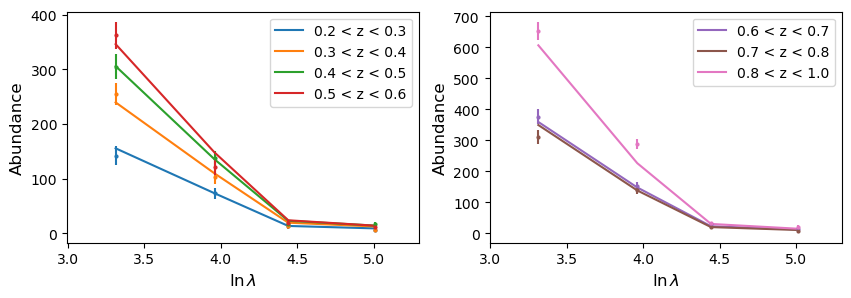

In [25]:
c = ['k', 'k', 'k', 'k', 'k', 'k', 'k']
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=None)
plt.figure(figsize=(10,3))
for i in range(len(Z_bin)):
    if i <= 3: plt.subplot(121)
    if i > 3: plt.subplot(122)
    z0 = analysis.Z_bin[i][0]
    z1 = analysis.Z_bin[i][1]
    Varth = N_mod_npnc[:,i]+NNSbb.diagonal()[i*4:(i+1)*4]
    #plt.plot(N_obs[:,i], Varth**.5/N_mod_npnc[:,i]**.5)
    plt.errorbar(np.log(np.mean(analysis.Obs_bin, axis=1)), N_obs[:,i], Varth**.5,  color = 'C'+str(i), marker = 'o', markersize=2, fmt=' ')
    plt.plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_npnc[:,i],color = 'C'+str(i), label =f'{z0:.1f} < z < {z1:.1f}' )
    plt.xlabel(r'$\ln \lambda$', fontsize=12)
    plt.ylabel('Abundance', fontsize=12)
    #plt.yscale('log')
    #plt.ylim(2, 3e3)
    plt.xlim(np.log(20), np.log(200))
    plt.legend()
    plt.tick_params(axis='both', which="both", labelsize= 10)
#plt.savefig('abundance_redmapper.png', bbox_inches='tight', dpi=300)

In [26]:
N_obs

array([[142., 255., 305., 362., 377., 312., 653.],
       [ 73., 104., 137., 122., 153., 139., 288.],
       [ 14.,  13.,  17.,  19.,  31.,  21.,  32.],
       [  6.,   6.,  17.,  12.,  14.,   7.,  22.]])

In [27]:
np.sum(N_obs[:,-1])/np.sum(N_obs.flatten())

0.2723788666849165

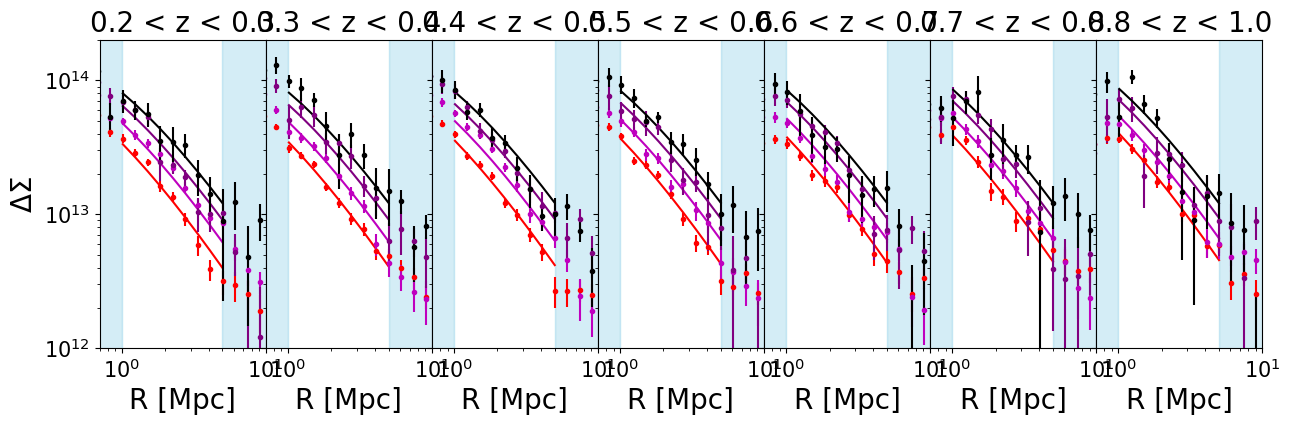

In [ ]:
color = ['r', 'm', 'purple', 'k']
fig, ax = plt.subplots(1, len(Z_bin), figsize=(15,4), sharey = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
for i, z_bin in enumerate(Z_bin):
    z0 = analysis.Z_bin[i][0]
    z1 = analysis.Z_bin[i][1]
    ax[i].set_title(f'{z0:.1f} < z < {z1:.1f}', fontsize=20)
    for j, richness_bin in enumerate(Richness_bin):
        ax[i].errorbar(r, DS_obs[:,j,i], Err_obs[:,j,i], fmt = ' ', marker = 'o', markersize=3, color=color[j])
        ax[i].loglog(r[(r > 1)*(r <= 5.5)], DS_mod[:,j,i][(r > 1)*(r <= 5.5)], color[j])
        ax[i].tick_params(axis='both', which="both", labelsize= 15)
        ax[i].set_xlabel('R [Mpc]', fontsize=20)
        ax[0].set_ylabel(r'$\Delta\Sigma$', fontsize=20)
        radius = np.linspace(0, 1, 100)
        ax[i].fill_between(radius, 0*radius + 1e16, alpha = .1, color = 'skyblue')# + 1e16)
        radius = np.linspace(5, 20, 100)
        ax[i].fill_between(radius, 0*radius + 1e16, alpha = .1, color = 'skyblue')
        ax[i].set_xlim(0.7, 10)
        ax[i].set_ylim(1e12, 2e14)
#plt.savefig('lensing_redmapper.png', bbox_inches='tight', dpi=300)

In [ ]:
mass_data = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/plots/WL_mean_masses/halomodel_nfw_freec.pkl')['masses']
log10Mass = np.zeros(N_obs.shape)
log10Mass_err = np.zeros(N_obs.shape)
for i, richness_bin in enumerate(Richness_bin):
    for j, redshift_bin in enumerate(Z_bin):
        maskz = (mass_data['z_mean'] > redshift_bin[0])*(mass_data['z_mean'] < redshift_bin[1])
        maskr = (mass_data['obs_mean'] > richness_bin[0])*(mass_data['obs_mean'] < richness_bin[1])
        mask = maskz * maskr
        mass_in_bin = mass_data[mask]
        log10Mass[i,j] = np.array(mass_in_bin['log10M200c_WL'])
        log10Mass_err[i,j] = np.array(mass_in_bin['err_log10M200c_WL'])

In [ ]:
NM = Omega * cl_mass.Cluster_dNd0mega_Mass_ProxyZ(bins, integrand_count = int_ds_count, grids = grids)
Mth = NM/N_mod_npnc

In [ ]:
color= ['C0', 'C1', 'C2', 'C3']
for i, redshift_bin in enumerate(Z_bin[:4]):
    plt.errorbar(np.log(np.mean(analysis.Obs_bin, axis=1)), log10Mass[:,i], log10Mass_err[:,i], fmt= ' ', color = color[i], marker = 'o')
    plt.errorbar(np.log(np.mean(analysis.Obs_bin, axis=1)), np.log10(Mth[:,i]), color = color[i])